In [2]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.9 MB/s eta 0:00:00


In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

In [4]:
# Loading the dataset
data = pd.read_csv('/content/Reviews.csv')
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [7]:
#Handling missing values
# Dropping rows where 'ProfileName', 'Summary', or 'Text' is missing
cleaned_data = data.dropna(subset=['ProfileName', 'Summary', 'Text'])

# Converting 'Time' column to datetime format
cleaned_data['Time'] = pd.to_datetime(cleaned_data['Time'], unit='s')

# Normalizing text data by lowercasing the 'Summary' and 'Text' columns
cleaned_data['Summary'] = cleaned_data['Summary'].str.lower()
cleaned_data['Text'] = cleaned_data['Text'].str.lower()

# Removing duplicates based on 'UserId', 'ProductId', and 'Text'
cleaned_data = cleaned_data.drop_duplicates(subset=['UserId', 'ProductId', 'Text'])

# Creating a new column for 'Helpfulness_Ratio' to avoid division by zero
cleaned_data['Helpfulness_Ratio'] = cleaned_data.apply(
    lambda row: row['HelpfulnessNumerator'] / row['HelpfulnessDenominator']
    if row['HelpfulnessDenominator'] > 0 else 0, axis=1)

# Display summary of cleaned data
cleaned_data.info(), cleaned_data.head()

<ipython-input-7-9a41e7f9b6c6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Time'] = pd.to_datetime(cleaned_data['Time'], unit='s')
<ipython-input-7-9a41e7f9b6c6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Summary'] = cleaned_data['Summary'].str.lower()
<ipython-input-7-9a41e7f9b6c6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

<class 'pandas.core.frame.DataFrame'>
Index: 567089 entries, 0 to 568453
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      567089 non-null  int64         
 1   ProductId               567089 non-null  object        
 2   UserId                  567089 non-null  object        
 3   ProfileName             567089 non-null  object        
 4   HelpfulnessNumerator    567089 non-null  int64         
 5   HelpfulnessDenominator  567089 non-null  int64         
 6   Score                   567089 non-null  int64         
 7   Time                    567089 non-null  datetime64[ns]
 8   Summary                 567089 non-null  object        
 9   Text                    567089 non-null  object        
 10  Helpfulness_Ratio       567089 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 51.9+ MB


(None,
    Id   ProductId          UserId                      ProfileName  \
 0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
 1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
 2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
 3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
 4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
 
    HelpfulnessNumerator  HelpfulnessDenominator  Score       Time  \
 0                     1                       1      5 2011-04-27   
 1                     0                       0      1 2012-09-07   
 2                     1                       1      4 2008-08-18   
 3                     3                       3      2 2011-06-13   
 4                     0                       0      5 2012-10-21   
 
                  Summary                                               Text  \
 0  good quality dog food  i have bought several of the vitalit

In [8]:
# Sampling 100,000 rows randomly
data_sampled = cleaned_data.sample(n=100000, random_state=42)

In [9]:
# Data cleaning and preprocessing
data_sampled = data_sampled.dropna(subset=['Summary', 'Text'])
data_sampled['Text'] = data_sampled['Text'].str.lower().str.replace(r'[^a-z0-9\s]', '', regex=True)

In [10]:
# Sentiment Analysis
data_sampled['Sentiment'] = data_sampled['Score'].apply(lambda x: 'positive' if x > 3 else ('neutral' if x == 3 else 'negative'))  # using lambda function and giving a condition i.e., if >3 is positive else if x=3 is neutral and <3 is negative
X_sentiment = data_sampled['Text']
y_sentiment = data_sampled['Sentiment']
vectorizer = TfidfVectorizer(max_features=5000) # using TfidVectorizer to extract the keywords in the text from the dataset
X_sentiment_tfidf = vectorizer.fit_transform(X_sentiment) # fitting the model
label_encoder = LabelEncoder() # using label encoder to convert categorical values to numerical values
y_sentiment_encoded = label_encoder.fit_transform(y_sentiment)

# using cross-validation and using logistic regression model
X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(X_sentiment_tfidf, y_sentiment_encoded, test_size=0.3, random_state=42)
sentiment_model = LogisticRegression(max_iter=200)
sentiment_model.fit(X_train_sentiment, y_train_sentiment)
y_pred_sentiment = sentiment_model.predict(X_test_sentiment)
print("Sentiment Analysis Report:")
print(classification_report(y_test_sentiment, y_pred_sentiment, target_names=label_encoder.classes_))

Sentiment Analysis Report:
              precision    recall  f1-score   support

    negative       0.74      0.63      0.68      4420
     neutral       0.52      0.18      0.27      2328
    positive       0.89      0.97      0.93     23252

    accuracy                           0.86     30000
   macro avg       0.71      0.59      0.62     30000
weighted avg       0.84      0.86      0.84     30000



comparing other classification models with logistic regression model to prove why logistic regression is the best model.

In [11]:
# Defining models for comparison for sentiment analysis
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Naive Bayes": MultinomialNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

# Train and evaluate each model
for model_name, model in models.items(): # iterating models inside a for loop
    print(f"\nModel: {model_name}")
    model.fit(X_train_sentiment, y_train_sentiment)
    y_pred_sentiment = model.predict(X_test_sentiment)

    # Displaying accuracy and classification report
    print("Accuracy:", accuracy_score(y_test_sentiment, y_pred_sentiment))
    print("Classification Report:\n", classification_report(y_test_sentiment, y_pred_sentiment, target_names=label_encoder.classes_))


Model: Logistic Regression
Accuracy: 0.8574666666666667
Classification Report:
               precision    recall  f1-score   support

    negative       0.74      0.63      0.68      4420
     neutral       0.52      0.18      0.27      2328
    positive       0.89      0.97      0.93     23252

    accuracy                           0.86     30000
   macro avg       0.71      0.59      0.62     30000
weighted avg       0.84      0.86      0.84     30000


Model: Random Forest
Accuracy: 0.833
Classification Report:
               precision    recall  f1-score   support

    negative       0.94      0.31      0.47      4420
     neutral       0.99      0.17      0.30      2328
    positive       0.83      1.00      0.90     23252

    accuracy                           0.83     30000
   macro avg       0.92      0.49      0.56     30000
weighted avg       0.85      0.83      0.79     30000


Model: Gradient Boosting
Accuracy: 0.8124666666666667
Classification Report:
               pr

since logistic regression model as the highest accuracy and precision among the others I have taken Logistic regression as the best model for SENTIMENT ANALYSIS

In [17]:
# FAKE REVIEW DETECTION

# Creating new features/columns
data_sampled['Helpfulness_Ratio'] = data_sampled['HelpfulnessNumerator'] / data_sampled['HelpfulnessDenominator'].replace(0, np.nan) #  If HelpfulnessDenominator is 0, replacing it with NaN to avoid division errors
data_sampled['Review_Length'] = data_sampled['Text'].str.len() # calculating length
data_sampled['Duplicate_Review'] = data_sampled.duplicated(subset=['UserId', 'Text'], keep=False) # identifying duplicate reviews
data_sampled['Review_Date'] = pd.to_datetime(data_sampled['Time'], unit='s') # conerting time column to date-time format

# Function to label reviews as "Fake" or "Not Fake"
def detect_fake_review(row):
   # setting thresholds
    helpfulness_threshold = 0.2
    length_threshold = 30
    duplicate_flag = row['Duplicate_Review']

    # Conditions for marking a review as "Fake"
    # if the helpfulnessratio or reviewlength is less than their threshold then given as "Fake" else "not fake"
    if (
        (row['Helpfulness_Ratio'] is not np.nan and row['Helpfulness_Ratio'] < helpfulness_threshold) or
        (row['Review_Length'] < length_threshold) or
        duplicate_flag
    ):
        return "Fake"
    else:
        return "Not Fake"

data_sampled['Fake_Review_Label'] = data_sampled.apply(detect_fake_review, axis=1)
data_sampled['Fake_Review_Label'] = data_sampled['Fake_Review_Label'].map({'Fake': 1, 'Not Fake': 0})

# Selecting features and labels
features = data_sampled[['Helpfulness_Ratio', 'Review_Length', 'Duplicate_Review', 'Score']]
features['Duplicate_Review'] = features['Duplicate_Review'].astype(int)
features['Helpfulness_Ratio'].fillna(0, inplace=True)
labels = data_sampled['Fake_Review_Label']

# cross-validation
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
 # defining models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Training and evaluating each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Model performance
    print(f"\nMOdel: {model_name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:", classification_report(y_test, y_pred))


<ipython-input-17-764c99b59ef8>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Duplicate_Review'] = features['Duplicate_Review'].astype(int)
<ipython-input-17-764c99b59ef8>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features['Helpfulness_Ratio'].fillna(0, inplace=True

Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



MOdel: Logistic Regression
Accuracy: 0.9511
Classification Report:               precision    recall  f1-score   support

           0       0.94      1.00      0.97     14768
           1       1.00      0.81      0.90      5232

    accuracy                           0.95     20000
   macro avg       0.97      0.91      0.93     20000
weighted avg       0.95      0.95      0.95     20000

Training Random Forest...

MOdel: Random Forest
Accuracy: 0.9476
Classification Report:               precision    recall  f1-score   support

           0       0.95      0.98      0.97     14768
           1       0.95      0.85      0.89      5232

    accuracy                           0.95     20000
   macro avg       0.95      0.92      0.93     20000
weighted avg       0.95      0.95      0.95     20000

Training Gradient Boosting...

MOdel: Gradient Boosting
Accuracy: 0.9553
Classification Report:               precision    recall  f1-score   support

           0       0.94      1.00      

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:55:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



MOdel: XGBoost
Accuracy: 0.9526
Classification Report:               precision    recall  f1-score   support

           0       0.94      1.00      0.97     14768
           1       0.99      0.83      0.90      5232

    accuracy                           0.95     20000
   macro avg       0.97      0.91      0.94     20000
weighted avg       0.95      0.95      0.95     20000



considering random forest as it gives us the best fit. logistic regression gives us highest accuracy but it may lead us to over-fitting so I'm taking random forest classifier as the best modle for "FAKE REVIEW DETECTION"

In [31]:
# Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.94765
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     14768
           1       0.95      0.85      0.89      5232

    accuracy                           0.95     20000
   macro avg       0.95      0.92      0.93     20000
weighted avg       0.95      0.95      0.95     20000



In [18]:
# Customer Segmentation
customer_features = data_sampled.groupby('UserId').agg({
    'Score': 'mean',
    'HelpfulnessNumerator': 'mean',
    'ProductId': 'count'
}).rename(columns={'ProductId': 'ReviewCount'})
kmeans = KMeans(n_clusters=3, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features)
print("\nCustomer Segmentation Clusters:")
print(customer_features['Cluster'].value_counts())


Customer Segmentation Clusters:
Cluster
1    70877
0      683
2       25
Name: count, dtype: int64


In [19]:
# Helpful Review Prediction

# Convert NaN values to 0 in the feature set
data_sampled['IsHelpful'] = data_sampled['Helpfulness_Ratio'] > 0.5
X_helpful = data_sampled[['Review_Length', 'Score', 'Helpfulness_Ratio']].fillna(0)
y_helpful = data_sampled['IsHelpful']

# Split the data into training and testing sets
X_train_helpful, X_test_helpful, y_train_helpful, y_test_helpful = train_test_split(X_helpful, y_helpful, test_size=0.3, random_state=42)

# Train the Gradient Boosting model
helpful_model = GradientBoostingClassifier()
helpful_model.fit(X_train_helpful, y_train_helpful)

# Predict and evaluate the model
y_pred_helpful = helpful_model.predict(X_test_helpful)
print("\nHelpful Review Prediction Report:")
print(classification_report(y_test_helpful, y_pred_helpful))



Helpful Review Prediction Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     17930
        True       1.00      1.00      1.00     12070

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



showing how TF-IDf vectorizer works i.e., how and what keywords it extracts from the text

In [20]:
# Aspect-Based Sentiment Analysis (Keyword Extraction)
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=500)
tfidf_vectorizer.fit_transform(data_sampled['Text'])
keywords = tfidf_vectorizer.get_feature_names_out()
print("\nTop Keywords for Aspect-Based Sentiment Analysis:")
print(keywords)


Top Keywords for Aspect-Based Sentiment Analysis:
['10' '100' '12' 'able' 'about' 'absolutely' 'actually' 'add' 'added'
 'after' 'again' 'ago' 'all' 'almost' 'also' 'although' 'always' 'am'
 'amazing' 'amazon' 'amount' 'an' 'and' 'another' 'any' 'anyone'
 'anything' 'are' 'around' 'arrived' 'as' 'at' 'available' 'away' 'baby'
 'back' 'bad' 'bag' 'bags' 'bar' 'bars' 'be' 'beans' 'because' 'beef'
 'been' 'before' 'being' 'best' 'better' 'big' 'bit' 'bitter' 'black'
 'blend' 'bold' 'both' 'bottle' 'bought' 'box' 'boxes' 'br' 'brand'
 'brands' 'bread' 'breakfast' 'brew' 'but' 'butter' 'buy' 'buying' 'by'
 'calories' 'came' 'can' 'candy' 'canned' 'cans' 'cant' 'case' 'cat'
 'cats' 'cereal' 'cheaper' 'cheese' 'chicken' 'chips' 'chocolate'
 'cinnamon' 'coconut' 'coffee' 'cold' 'come' 'comes' 'company' 'cookie'
 'cookies' 'corn' 'cost' 'could' 'couldnt' 'couple' 'cream' 'crunchy'
 'cup' 'cups' 'dark' 'day' 'days' 'deal' 'decided' 'definitely'
 'delicious' 'did' 'didnt' 'diet' 'difference' 'di

<ipython-input-21-5aebff0bbe21>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_score = data_sampled.resample('M', on='Date')['Score'].mean()


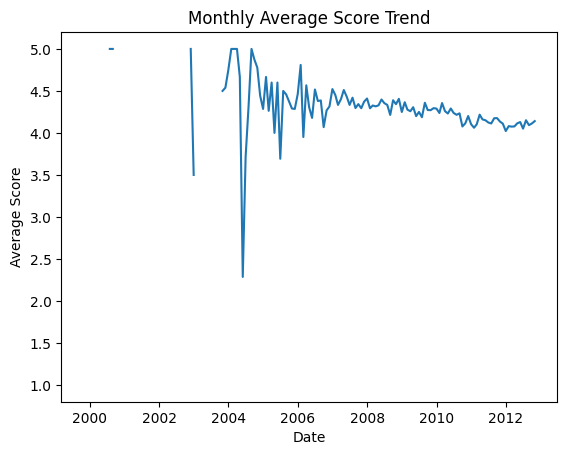

In [21]:
# Trend Analysis over Time
data_sampled['Date'] = pd.to_datetime(data_sampled['Time'], unit='s')
monthly_avg_score = data_sampled.resample('M', on='Date')['Score'].mean()
plt.plot(monthly_avg_score.index, monthly_avg_score.values)
plt.xlabel('Date')
plt.ylabel('Average Score')
plt.title('Monthly Average Score Trend')
plt.show()

In [22]:
# Anomaly Detection Proportion

# Converting NaN values to 0
anomaly_features = data_sampled[['Score', 'Review_Length', 'Helpfulness_Ratio']].fillna(0)

# Run IsolationForest on the modified data
isolation_forest = IsolationForest(contamination=0.01)
data_sampled['Anomaly'] = isolation_forest.fit_predict(anomaly_features)

# Print anomaly detection proportion
print("\nAnomaly Detection Proportion:")
print(data_sampled['Anomaly'].value_counts(normalize=True))



Anomaly Detection Proportion:
Anomaly
 1    0.99002
-1    0.00998
Name: proportion, dtype: float64


now doing visulaization on the dataset as well as the derived outputs

<ipython-input-23-b17d311772c6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Score', data=data_sampled, palette='viridis')


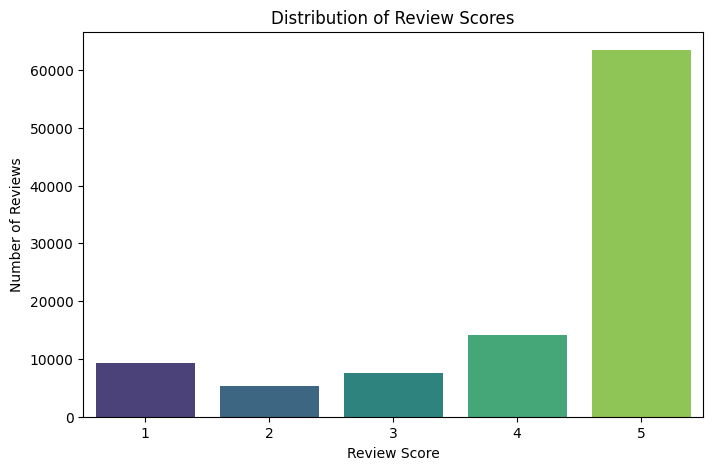

In [23]:
# Plot distribution of review scores
plt.figure(figsize=(8, 5))
sns.countplot(x='Score', data=data_sampled, palette='viridis')
plt.title("Distribution of Review Scores")
plt.xlabel("Review Score")
plt.ylabel("Number of Reviews")
plt.show()


<ipython-input-24-f8ac8a776ffd>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=data_sampled, palette='coolwarm')


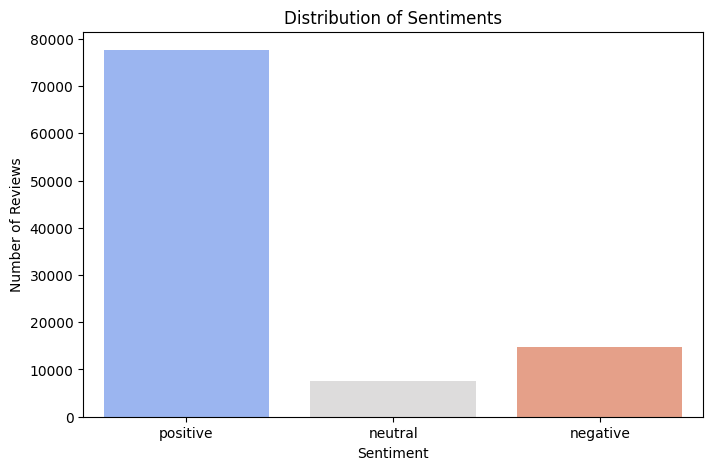

In [24]:
# sentiment analysis distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment', data=data_sampled, palette='coolwarm')
plt.title("Distribution of Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

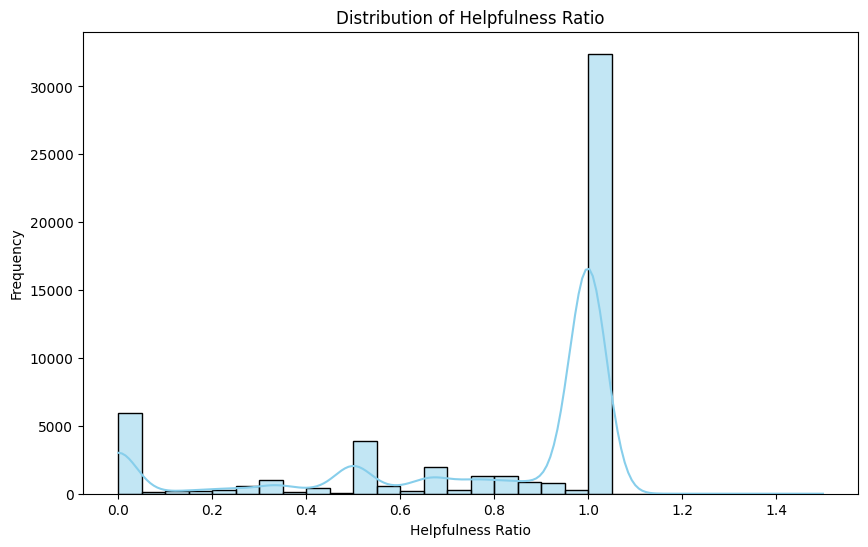

In [26]:
# helpfulness_ratio distribution
plt.figure(figsize=(10, 6))
sns.histplot(data_sampled['Helpfulness_Ratio'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Helpfulness Ratio")
plt.xlabel("Helpfulness Ratio")
plt.ylabel("Frequency")
plt.show()

<ipython-input-27-43b89e9e8410>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_score = data_sampled.resample('M', on='Date')['Score'].mean()


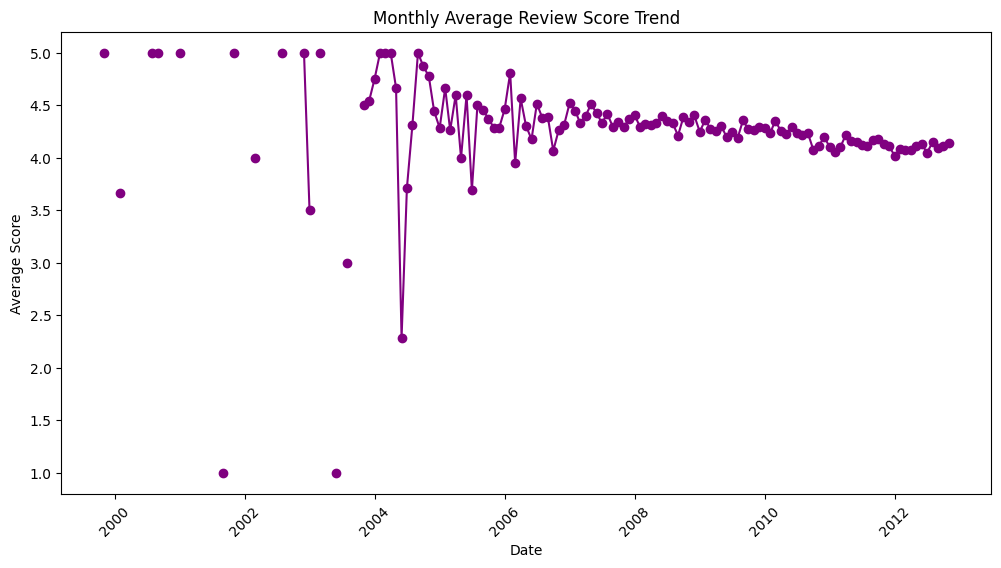

In [27]:
# trend of review score over date
data_sampled['Date'] = pd.to_datetime(data_sampled['Time'], unit='s')
monthly_avg_score = data_sampled.resample('M', on='Date')['Score'].mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_score.index, monthly_avg_score.values, marker='o', color='purple')
plt.title("Monthly Average Review Score Trend")
plt.xlabel("Date")
plt.ylabel("Average Score")
plt.xticks(rotation=45)
plt.show()


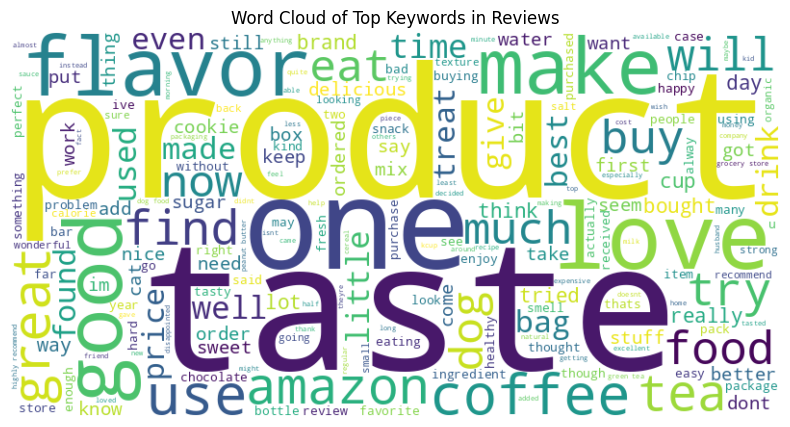

In [28]:
# wordcloud of reviews
# Generate word cloud from text data
text = " ".join(review for review in data_sampled['Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Top Keywords in Reviews")
plt.show()


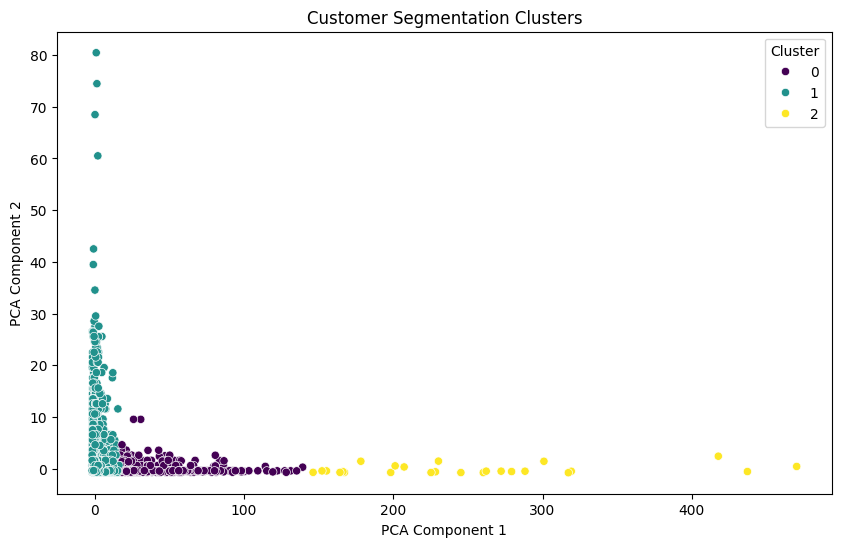

In [29]:
# customer segmentation

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
customer_features_pca = pca.fit_transform(customer_features[['Score', 'HelpfulnessNumerator', 'ReviewCount']])
customer_features['PCA1'] = customer_features_pca[:, 0]
customer_features['PCA2'] = customer_features_pca[:, 1]

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_features, palette='viridis')
plt.title("Customer Segmentation Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

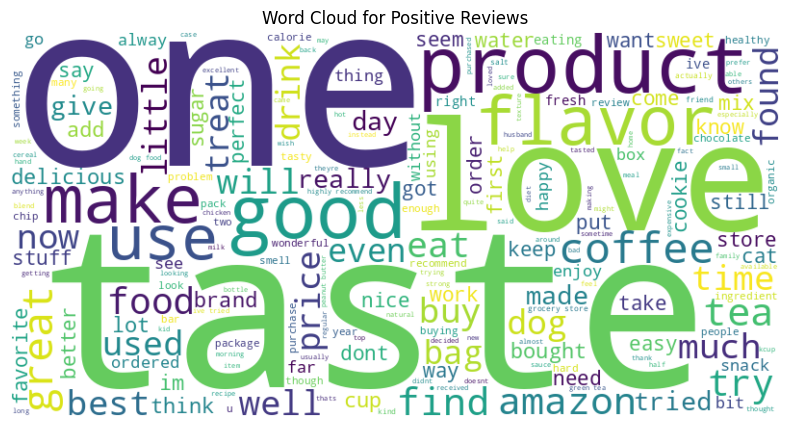

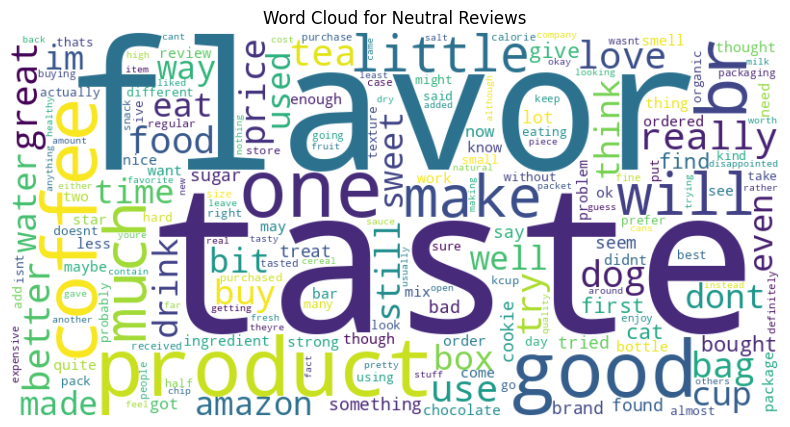

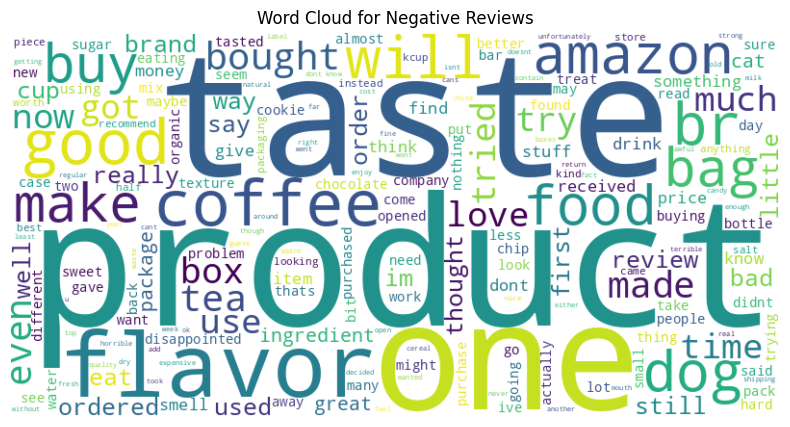

In [30]:
# wordcloud for sentiments(positive, neutral and negative reviews)

# Generate word clouds for each sentiment
for sentiment in data_sampled['Sentiment'].unique():
    sentiment_text = " ".join(review for review in data_sampled[data_sampled['Sentiment'] == sentiment]['Text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sentiment_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {sentiment.capitalize()} Reviews")
    plt.show()